In [1]:
# standard python utilities
import os
from os.path import join, exists, dirname, basename
import sys
import glob
import pandas as pd
import numpy as np
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
# import pyproj # for converting proj4string
# import shapely
import geopandas as gpd
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

In [2]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
    
# dir of all gwfm data
gwfm_dir = join(dirname(doc_dir),'Box/research_cosumnes/GWFlowModel')
dis_dir = join(gwfm_dir,'DIS_data')
print(gwfm_dir)

flopy_dir = doc_dir+'/GitHub/flopy'
if flopy_dir not in sys.path:
    sys.path.insert(0, flopy_dir)
import flopy 


C:\Users\ajcalder\Box/research_cosumnes/GWFlowModel


In [3]:
from flopy.utils import Raster # for ET resampling


In [4]:
# New model domain 52.9 deg
m_domain = gpd.read_file(join(dis_dir,'NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp'))


In [5]:
xll, yll = list(m_domain.geometry.values[0].exterior.coords)[0]
#Maribeth's model parameters, had to switch nrow and ncol due to her issue in xul, yul
nrow=100
ncol=230
delr=np.repeat(200,ncol)
delc=np.repeat(200,nrow)
rotation=52.9
modelgrid = flopy.discretization.StructuredGrid(xoff=xll, yoff=yll, proj4='EPSG:32610', angrot=rotation,
                                   delr=delr, delc=delc, nrow=nrow,ncol=ncol)

### Crop coefficients and ETo

In [6]:

uzf_dir = join(gwfm_dir,'UZF_data')

crop_path = join(uzf_dir,'county_landuse')
crop_shp_names = glob.glob(crop_path+'/*.shp')
crop_shp_names


['C:\\Users\\ajcalder\\Box/research_cosumnes/GWFlowModel\\UZF_data\\county_landuse\\i15_LandUse_Sacramento1993.shp',
 'C:\\Users\\ajcalder\\Box/research_cosumnes/GWFlowModel\\UZF_data\\county_landuse\\i15_LandUse_Sacramento2000.shp',
 'C:\\Users\\ajcalder\\Box/research_cosumnes/GWFlowModel\\UZF_data\\county_landuse\\i15_LandUse_Sacramento2015.shp',
 'C:\\Users\\ajcalder\\Box/research_cosumnes/GWFlowModel\\UZF_data\\county_landuse\\i15_LandUse_SanJoaquin1996.shp',
 'C:\\Users\\ajcalder\\Box/research_cosumnes/GWFlowModel\\UZF_data\\county_landuse\\i15_LandUse_SanJoaquin2017.shp']

### Reference crop class letter to the name

In [7]:
# land use referencing for DWR data (class, subclass, irrigation)
lu_class = pd.read_excel(join(uzf_dir,'DWR_landuse_ref.xlsx'), sheet_name = 'class' )
# clean up file, needed before saved over
# lu_class.name = lu_class.name.str.split('(', expand=True)[0]
# lu_class.name = lu_class.name.str.strip()

# files already clean
lu_subclass = pd.read_excel(join(uzf_dir,'DWR_landuse_ref.xlsx'), sheet_name = 'subclass' )
lu_irrig = pd.read_excel(join(uzf_dir,'DWR_landuse_ref.xlsx'), sheet_name = 'irrigation' )
lu_irrig.code = lu_irrig.code.str.strip()

# # join with subclass file so if subclass doesn't exist then the bulk class is used
lu_class = pd.concat((lu_class,lu_subclass))

### Prepare spatial data
Due to the location, there are multiple county datasets required for the model domain. Additionally there are different datasets for certain years which need to be joined, these will later be filtered depending on the year of climate data.  
The spatial data will be joined to the model grid before joining to the time series data because the model grid will be used to dissolve the data to each node.  
\* the majority of parcels are single cropped, but still need to resolve those that are not by removing or accounting for crop sequences. For single crops the value to the cell is 100%, for intercropped need to check the percentage.
- Now with the parcel data it is easier to spatial join the shapefile to the location of WCRs in the domain and filter to one or two to apply the pumping.

In [8]:
# join all the crop shapefile together
lu_all = gpd.GeoDataFrame()
# lu_yr = gpd.read_file(glob.glob(crop_path+'/*Sacramento2000.shp')[0])
for n in np.arange(0, len(crop_shp_names)):
    # load land use file
    lu_yr = gpd.read_file(crop_shp_names[n])
    # crop to model domain
    lu_yr = gpd.overlay(lu_yr, m_domain.to_crs(lu_yr.crs))
    # add id to use when pivoting dataframe
    lu_yr['geom_id'] = np.arange(0, len(lu_yr))
    # append to joint dataframe
    lu_all = pd.concat((lu_all, lu_yr.to_crs(m_domain.crs)))

In [9]:
# find columns that use numbers as identifiers
melt_cols = lu_all.columns[lu_all.columns.str.contains(fr'\D\d')]
melt_cols = melt_cols[~melt_cols.str.contains('AREA')]
id_cols = lu_all.columns[~lu_all.columns.isin(melt_cols)]
# melt the data to create clean columns broken up by crop numbers
lu_long = lu_all.melt(value_vars = melt_cols,
           id_vars = id_cols
                     ) 

In [10]:
# split into pieces
# main variable name (e.g. CLASS or PCNT)
lu_long['var_nam'] = lu_long.variable.str.extract(r'(\D+)')
# identify crop number 1, 2, or 3
lu_long['crop_num'] = lu_long.variable.str.extract(r'(\d+)')
# extra id, relevant to irrigation with PA (irrig bool) and PB (irrig typ)
lu_long['irr_id'] = lu_long.variable.str.extract(r'\D+\d+(\D+)')
# add irrigation id back, to avoid NAs when pivoting wide as each crop needs both variables
lu_long.loc[~lu_long.irr_id.isna(), 'var_nam'] += '_'+lu_long.loc[~lu_long.irr_id.isna(), 'irr_id']

In [11]:
# columns to keep as indexers for crops
index_cols = ['WATERSOURC', 'MULTIUSE', 'crop_num', 
              'SURVEYAREA','SURVEYYEAR',
              'geom_id','geometry']

In [12]:
# must use pivot which requires non-duplicated entries, pivot_table aggregates
lu_wide = lu_long.pivot(columns='var_nam', index=index_cols, values='value').reset_index()

# convert subclass to numeric with coercion (make ** to NaN)
# it is still not clear what ** are for
lu_wide.SUBCLASS= pd.to_numeric(lu_wide.SUBCLASS, errors='coerce')
# make -1 subclass for when one doesn't exist (avoids dealing with NAs)
lu_wide.loc[lu_wide.SUBCLASS.isna(), 'SUBCLASS'] = -1

In [13]:
# join by class and subclass to get crop name
lu_classed = lu_wide.join(lu_class.set_index(['class', 'subclass']), on=['CLASS', 'SUBCLASS'])
# many are still unknown but key point is knowing irrigation or not
lu_classed = lu_classed.join(lu_irrig.set_index('code'),on='IRR_TYP_PB')
# convert back to geodataframe
lu_classed = gpd.GeoDataFrame(lu_classed, crs = lu_long.crs)
# for some reason, 2015 came in as a string
lu_classed.SURVEYYEAR = pd.to_numeric(lu_classed.SURVEYYEAR)

# drop cells that were outside the survey area
lu_classed = lu_classed[lu_classed.CLASS !='Z']
# clean up survey area name
lu_classed['county'] = lu_classed.SURVEYAREA.str.replace(' COUNTY','').copy()
# simple name for plot
lu_classed['name_plot'] = lu_classed.name.str.split(' ',expand=True)[0]
# drop crops that don't have a name as they won't have a crop coefficient
# these are mostly urban which can be filtered separately to identify areas of runoff, etc.
lu_classed = lu_classed.dropna(subset='name')
# convert PCT column to numeric and if single/double cropped the percentage should be 100
# I, M, S have PCNT >20
# 00 represents 100%, while ** means not used
lu_classed.PCNT = lu_classed.PCNT.str.replace('00','100')
lu_classed['PCNT'] = pd.to_numeric(lu_classed.PCNT, errors='coerce')

In [14]:
# subset for urban and native classes
lu_urban = lu_classed[lu_classed.name.str.contains('urban', case=False)]
lu_native = lu_classed[lu_classed.name.str.contains('native', case=False)]
# filter for those crops that are considered irrigated
lu_crops = lu_classed.dropna(subset='irr_name')
non_irrig = ['Unknown or not mapped', 'Wild Flooding']
lu_crops = lu_crops[~lu_crops.irr_name.isin(non_irrig)]

C:\Users\ajcalder\Anaconda3\envs\geo_env\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

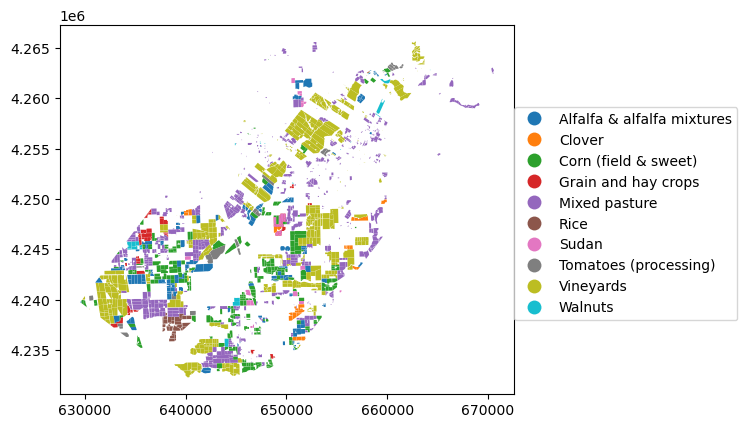

In [15]:
lu_plt = lu_crops[lu_crops.SURVEYYEAR==2015]
# lu_plt.plot('irr_name',legend=True, legend_kwds={'ncol':1, 'loc':(1,0.2)})
# plot key categories
lu_plt['area_m2'] = lu_plt.geometry.area.copy()
lu_perc = 100*lu_plt.groupby('name').sum(numeric_only=True)['area_m2']/lu_plt.area_m2.sum()
lu_plt[lu_plt.name.isin(lu_perc[lu_perc>1].index)].plot('name',legend=True, legend_kwds={'ncol':1, 'loc':(1,0.2)})

In [16]:
# a 0.1% land area cutoff covers 99% of land use
cutoff = 0.2
print('%.1f %% land covered' %(lu_perc[lu_perc>cutoff].sum()), 'with %.1f %% cuttoff' % cutoff)
print('And drops %i crops' %(lu_perc.shape[0] - lu_perc[lu_perc>cutoff].shape[0]))

98.4 % land covered with 0.2 % cuttoff
And drops 20 crops


In [17]:
# S = single,  D = double and T = triple (cropped following each other), 
# I = inter cropped (orchards with annual grasses), M = multi,
# sac_lu_2000.MULTIUSE.unique()

print('%.1f%% are single cropped ' %(lu_crops[lu_crops.MULTIUSE=='S'].shape[0]*100/lu_crops.shape[0])) 

95.2% are single cropped 


In [18]:
# A-B, A-C, A-D are the percent of the season for each Kc
# The dates are the dates of the growing season
Kc = pd.read_csv(join(uzf_dir,'Kc/Kc_Current.csv'),skiprows = 1)
Kc = Kc.rename(columns={'Unnamed: 0' : 'Match_kc'})

# Kc reference sheet to convert names from Kc_current to DWR format
kc_ref = pd.read_excel(join(uzf_dir,'DWR_landuse_ref.xlsx'), sheet_name = 'Kc_match' )
Kc = kc_ref[['Match_kc','name']].join(Kc.set_index('Match_kc'), on='Match_kc', how='inner').reset_index()

## Rainfall and ET data from CIMIS

In [19]:
## Potential ETo spatial interpolation from CIMIS
fn = glob.glob(join(uzf_dir,'Cosumnes_dailyET_precip*.csv'))
daily_data = pd.DataFrame()
for file in fn:
    new_data = pd.read_csv(file, index_col = ['Date'], parse_dates = True)
    daily_data = pd.concat((daily_data, new_data))
    
# sensor locations
coords = pd.read_csv(join(uzf_dir,'CIMIS_station_lat_long.csv'), index_col = 0)
coords = gpd.GeoDataFrame(coords,geometry = gpd.points_from_xy(coords['Long'] ,coords['Lat']))
# Convert WGS Lat and long to Easting and Northing in Zone 10N
coords.crs = 'epsg:4326'
coords = coords.to_crs('epsg:32610')


<Axes: >

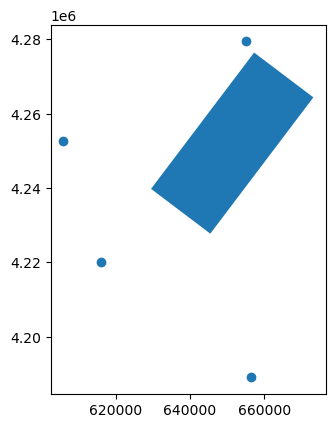

In [20]:
fig,ax = plt.subplots()
coords[coords['Stn Name'].isin(['Manteca','Dixon','Fair Oaks', 'Twitchell Island'])].plot(ax=ax)
m_domain.plot(ax=ax)

# fair oaks really is the closest, and ET doesn't vary much between stations anyway. previously I did a little analysis
# on rainfall data but I remember not a lot being consistently available at eagles nest or having errors

In [21]:
# units of mm
data_in = daily_data[daily_data['Stn Name']=='Fair Oaks']
# clean up data so columns are by location, units of ETo are in mm
ET = data_in.pivot_table(index = 'Date', columns = 'Stn Name', values = 'ETo (mm)')
# clean up data so columns are by location, units of Precip are in mm
rain = data_in.pivot_table(index = 'Date', columns = 'Stn Name', values = 'Precip (mm)')

# convert from mm to m
ET_m = ET/1000
rain_m = rain/1000

### Create monthly values of ET and rain

C:\Users\ajcalder\Anaconda3\envs\geo_env\lib\site-packages\pandas\plotting\_matplotlib\core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


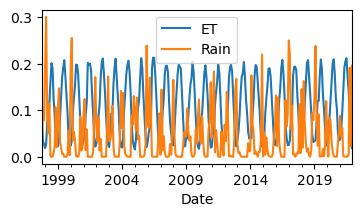

In [22]:
monthly_ET = ET_m.resample('M').sum()
monthly_rain = rain_m.resample('M').sum()
fig,ax = plt.subplots(figsize=(4,2))
monthly_ET.plot(ax=ax)
monthly_rain.plot(ax=ax)
plt.legend(['ET','Rain'])

In [23]:
def calc_kc_dates(year, domain_dbf):
    # The year for each crop for each set of dates needs to change iteratively for each crop individually because
    # some crops have dates that extend into the next year that must not change until the final date of the 
    # season is reached (e.g. 2018-11-01 to 2019-09-17 must stay 2018 and 2019 until 2019-09-17 is reached)
#     i = 2018
#     dates = domain_dbf.loc[:,['Beg Month','Beg Day', 'End Month', 'End Day', 'A-B', 'A-C', 'A-D']]
    dates = domain_dbf.copy()
    
    # Set the pandas datetime from the start and end dates of crops
    # need to just takes .values or indexing will be wrong and mismatch dates to rows
    dates['A'] = pd.to_datetime({'year': year, 'month':dates['Beg Month'].values, 'day': dates['Beg Day'].values}).values
    dates['E'] = pd.to_datetime({'year': year, 'month':dates['End Month'].values, 'day': dates['End Day'].values}).values
    # Make correction for any end dates that are in the next year
    dates.loc[dates.E < dates.A, 'E'] += pd.offsets.DateOffset(years=1)

    # Get the length of the growing periods
    dates['num_days'] = dates.E-dates.A
    # set the end date of growing period A/ start of period B
    dates['B'] = dates.A + dates.num_days*(dates['A-B']/100)
    # Round the dates, as we will be one a daily time step
    dates.B = pd.to_datetime(dates.B.dt.date)
    # # set the end date of growing period B/ start of period C
    dates['C'] = dates.B + dates.num_days*((dates['A-C']-dates['A-B'])/100)
    # # set the end date of growing period C/ start of period D
    dates['D'] = dates.C + dates.num_days*((dates['A-D']-dates['A-C'])/100)
    return(dates)

In [24]:
# kc_dates = calc_kc_dates(2000, Kc)
# kc_dates

In [25]:
# kc_time = pd.DataFrame(columns=['date','name', 'Kc'])
# kc_time

In [26]:
strt_date = rain.index.min()
end_date = rain.index.max()

In [27]:
#calculate ETc for each date
ETc = ET_m.copy()
# iterate across years becaues it is easiest to create Kc dates for each year
for y in np.arange(strt_date.year+1, end_date.year):
    kc_dates = calc_kc_dates(y, Kc)
    # iterate across crops to create an ETc column
    for crop in kc_dates.name:
        crop_kc = kc_dates[kc_dates.name==crop].iloc[0]
        ETc.loc[crop_kc.A:crop_kc.B, crop_kc['name']] = ET_m.loc[crop_kc.A:crop_kc.B].iloc[:,0] * crop_kc.Kc1
        ETc.loc[crop_kc.B:crop_kc.C, crop_kc['name']] = ET_m.loc[crop_kc.B:crop_kc.C].iloc[:,0] * crop_kc.Kc2
        ETc.loc[crop_kc.C:crop_kc.D, crop_kc['name']] = ET_m.loc[crop_kc.C:crop_kc.D].iloc[:,0] * crop_kc.Kc3
        ETc.loc[crop_kc.D:crop_kc.E, crop_kc['name']] = ET_m.loc[crop_kc.D:crop_kc.E].iloc[:,0] * crop_kc.Kc4

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_66108\888085432.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ETc.loc[crop_kc.A:crop_kc.B, crop_kc['name']] = ET_m.loc[crop_kc.A:crop_kc.B].iloc[:,0] * crop_kc.Kc1
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_66108\888085432.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ETc.loc[crop_kc.A:crop_kc.B, crop_kc['name']] = ET_m.loc[crop_kc.A:crop_kc.B].iloc[:,0] * crop_kc.Kc1
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_66108\888085432.py:9: PerformanceWarning: DataFrame i

In [28]:
ETc_long = ETc.melt(ignore_index=False)
# remove NA values
ETc_long = ETc_long.dropna()
# for the ETc there is no need to keep 0 values because the wel package doesn't need 0 values
# and if converting to an array format for UZF the default value is zero
ETc_long = ETc_long[ETc_long.value!=0]

In [29]:
# et_cols = ['Fair Oaks', 'Alfalfa and alfalfa mixtures', 'Wine grapes', 'Native vegetation', 'Native pasture']
# ETc['2012-10-1':'2014-10-1'].plot(y=et_cols)

In [30]:
# ET.loc[crop_kc.B:crop_kc.C]
# ETc.plot(y='Almonds')
# ETc.loc[crop_kc.B: crop_kc.C, 'Almonds']
# ET.loc[crop_kc.B: crop_kc.C].iloc[:,0]
# ETc

### Prepare data for the model grid
1. Identify the proper polygons to use for each year based on the SURVEYYEAR
2. Join to the model grid
3. ID join by crop name to the ETc data
4. Dissolve the data to each node and save as an array or dataframe to hdf5.

*Alternate* - Instead of calculating rates at each cell I could keep the rate calculated for each parcel and it just has to be applied to individual wells.

In [31]:
# New model domain 52.9 deg
# m_domain = gpd.read_file(gwfm_dir+'/DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp')

grid_p = gpd.read_file(join(dis_dir, 'grid/grid.shp'))

In [32]:
wells = pd.read_csv(gwfm_dir+'/WEL_data/all_wells_type.csv', dtype = {'default':object})
wells_grid = gpd.GeoDataFrame(wells, geometry = gpd.points_from_xy(wells.easting,wells.northing), 
                              crs = 'epsg:32610')
well_strt_date = '2015-10-01'
wells_grid.DateWorkEnded = pd.to_datetime(wells_grid.DateWorkEnded )
wells_grid['well_age_days'] = (pd.to_datetime(well_strt_date) - wells_grid.DateWorkEnded).dt.days
# # remove wells older than 60 years for ag, think of Teichert wells from 60s (domestic wells age out earlier)
# wells_grid = wells_grid[wells_grid.well_age_days < 60*365]
# only want irrigation wells
# wells_grid = wells_grid[wells_grid.Simple_type == 'irrigation']

wells_grid.row = (wells_grid.row-1).astype(int)
wells_grid.column = (wells_grid.column -1).astype(int)

# for properties with multiple wells the options are: 
# 1. choose the newest well or 2. split pumping among wells 3. use avg well properties
# if well ages are similar and property is large then multiple wells make sense
# wells_grid_ag = wells_grid.loc[wells_grid.Simple_type == 'irrigation'].dissolve('node', aggfunc = 'mean')


In [43]:
# save typical land use types to shapefile for quick reference of cultivated, urban or pasture
# from years just after new surveys
for y in [2001, 2018]:
    lu_crops['yr_diff'] = (y - lu_crops.SURVEYYEAR.copy() )
    # find the best year for land use data for each year
    pick_yrs = lu_crops[lu_crops['yr_diff']>0].groupby('county').min(numeric_only=True)
    pick_yrs['year'] = (y-pick_yrs.yr_diff)
    pick_yrs = pick_yrs[['year']].set_index('year', append=True)
    # pull out data for year
    lu_yr = lu_crops.join(pick_yrs, on=['county','SURVEYYEAR'], how='inner')
    lu_native_yr = lu_native.join(pick_yrs, on=['county','SURVEYYEAR'], how='inner')
    lu_urban_yr = lu_urban.join(pick_yrs, on=['county','SURVEYYEAR'], how='inner')
    lu_yr.to_file(join(crop_path, 'domain_ag_lu_'+str(y)+'.shp'))
    lu_native_yr.to_file(join(crop_path, 'domain_native_lu_'+str(y)+'.shp'))
    lu_urban_yr.to_file(join(crop_path, 'domain_urban_lu_'+str(y)+'.shp'))

In [236]:
def lu_to_grid_ETc(lu_yr, grid_p, ETc_long):
     # Take gridded land use data and join to ETc data aggregate to the grid cell level 
     
    # use overlay to keep cropped geometry to check area in each cell
    lu_grid = gpd.overlay(lu_yr, grid_p)
    cell_area = grid_p.geometry.area.mean().round(0)
    # account for the area of each cell covered by a crop polygon
    lu_grid['cell_pct'] = lu_grid.geometry.area/cell_area

    # ID join land use grid and ETc
    etc_grid = lu_grid.join(ETc_long[ETc_long.index.year==y].reset_index().set_index('Stn Name'), on='name', how='inner')

    # calculate the average crop evapotranspiration for each cell for each timestep
    # multiplly ET by the percent of the area covered by the crop to account for intercropped areas
    etc_grid['etc_pct'] = etc_grid.value * pd.to_numeric(etc_grid.PCNT)/100
    # scale the ETc to the cell rate by multiplying by cell fraction
    etc_grid['etc_cell'] = etc_grid.etc_pct * etc_grid.cell_pct
    # aggregate the crop data to the cell level by summing the rates that were scaled
    # need to groupby crop_num as well for those double/triple cropped
    etc_grid_sum = etc_grid.groupby(['Date','node', 'row','column','crop_num']).sum(numeric_only=True).reset_index('crop_num')
    # when double/triple crop exists, aggregate by date, node taking the first row (precedence to crop_num 1)
    etc_grid_sum.groupby(['Date','node','row','column']).first()
    etc_grid_sum = etc_grid_sum.reset_index(['node','row','column'])
    etc_grid_sum['yr_index'] = etc_grid_sum.index.dayofyear.values-1
    # need to use this date workaround because not all dates are in ETc
    etc_arr = np.zeros((pd.Timestamp(y, 12, 31).dayofyear, nrow,ncol))
    etc_arr[etc_grid_sum.yr_index, etc_grid_sum.row-1, etc_grid_sum.column-1] = etc_grid_sum.etc_cell
    return(etc_arr)

In [228]:
# etc_yr = lu_to_grid_ETc(lu_yr, grid_p, ETc_long)

In [229]:
import h5py
# ends up as about 500 MB, may want individual files

def arr_to_h5(arr, h5_fn):
    # convert arrays of annual etc to hdf5 files individually
    f = h5py.File(h5_fn, "w")
    grp = f.require_group('array') # makes sure group exists
    grp.attrs['units'] = 'meters/day'
    grp.attrs['description'] = 'Each layer of the array is a day in the year'
    dset = grp_irr.require_dataset(str(y), arr.shape, dtype='f', compression="gzip", compression_opts=4)
    dset[:] = arr
    f.close()



In [237]:
# takes 10+ min or so
# one year of data is 200 MB compared to 400MB of 20 yrs compressed
# need to save individual files to reduce file size, and hdf5 is needed for compression
t0 = time.time()
for y in np.arange(strt_date.year+1, end_date.year):
    lu_crops['yr_diff'] = (y - lu_crops.SURVEYYEAR.copy() )
    # find the best year for land use data for each year
    pick_yrs = lu_crops[lu_crops['yr_diff']>0].groupby('county').min(numeric_only=True)
    pick_yrs['year'] = (y-pick_yrs.yr_diff)
    pick_yrs = pick_yrs[['year']].set_index('year', append=True)
    # pull out data for year
    lu_yr = lu_crops.join(pick_yrs, on=['county','SURVEYYEAR'], how='inner')
    etc_yr = lu_to_grid_ETc(lu_yr, grid_p, ETc_long)
    arr_to_h5(etc_yr, join(uzf_dir, "dwr_ETc/irrigated_"+str(y)+".hdf5"))

    # pull out data for year
    lu_native_yr = lu_native.join(pick_yrs, on=['county','SURVEYYEAR'], how='inner')
    etc_native_yr = lu_to_grid_ETc(lu_native_yr, grid_p, ETc_long)
    arr_to_h5(etc_native_yr, join(uzf_dir, "dwr_ETc/native_"+str(y)+".hdf5"))
t1 = time.time()
print((t1-t0)/60)

14.040857442220052


In [1054]:
# only 30% of wells intersected
wells_lu = gpd.sjoin(wells_grid, lu_yr, how='inner') 
print('%.1f %% wells are in a land use polygon' %(wells_lu.shape[0]*100/wells_grid.shape[0]))
# the WCRs do not match up enough with the land use parcels to use them to apply pumping
print('%.1f %% land use parcels have a WCR' %(wells_lu.shape[0]*100/lu_yr.shape[0]))
# fig,ax = plt.subplots()
# lu_yr.plot(ax=ax, alpha=0.6)
# wells_grid.plot(ax=ax, color='red', markersize=0.3)
# wells_lu.plot(ax=ax, color='blue', markersize=0.3)


10.5 % wells are in a land use polygon
10.6 % land use parcels have a WCR


## Determining locations of ag land for logical array and plotting
Create an output array for each year of estimated land use. This will then be read in to the model before creating the well package to determine which cells should estimate groundwater pumping based on applied water (ETc).
This could be further improved by looking at the EWRIMS (water rights) system to determine which sites are surafce water irrigated. These maps are adjusted based on the location of agricultural pumps to validate their definition as groundwater pumping.

## Plot floodplain like lands